In [1]:
#Import modules #Run this once
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
#directories
try:
    parentdir
except NameError:
    parentdir=os.getcwd()
else:
    parentdir = parentdir
print('The working directory is parentdir: %s' %parentdir)

The working directory is parentdir: D:\Research\Reports_ppt\reports\AzurinSM-MS4\Azurin_SM_repo\Analysis


# Simulation

***Parameters for simulation***

The on off times should follow the relation:

$$E = E_0 + \frac{k_BT}{ne}log_{10}(\frac{\tau_{on}}{\tau_{off}})$$

We will simulate time trace at $75~mV$ with $E_0 = 5mV$

From expreimental analysis: $\tau_{off} = 0.25~s$ and $\tau_{on} = 0.02~s$

But we can also estimate the expected value  as follow of $\tau_{on}$ instead of directly giving the value.

In [2]:
E=75; E0=5; toff=0.25; # give potential value in mV and time in seconds
ton = toff*(10**((E0-E)/59));
print('tov value is:', ton)

tov value is: 0.016274188076145425


***Run the function here***

In [5]:
%run simulation.py

## simulate_on_off_time

numpoint: 3846


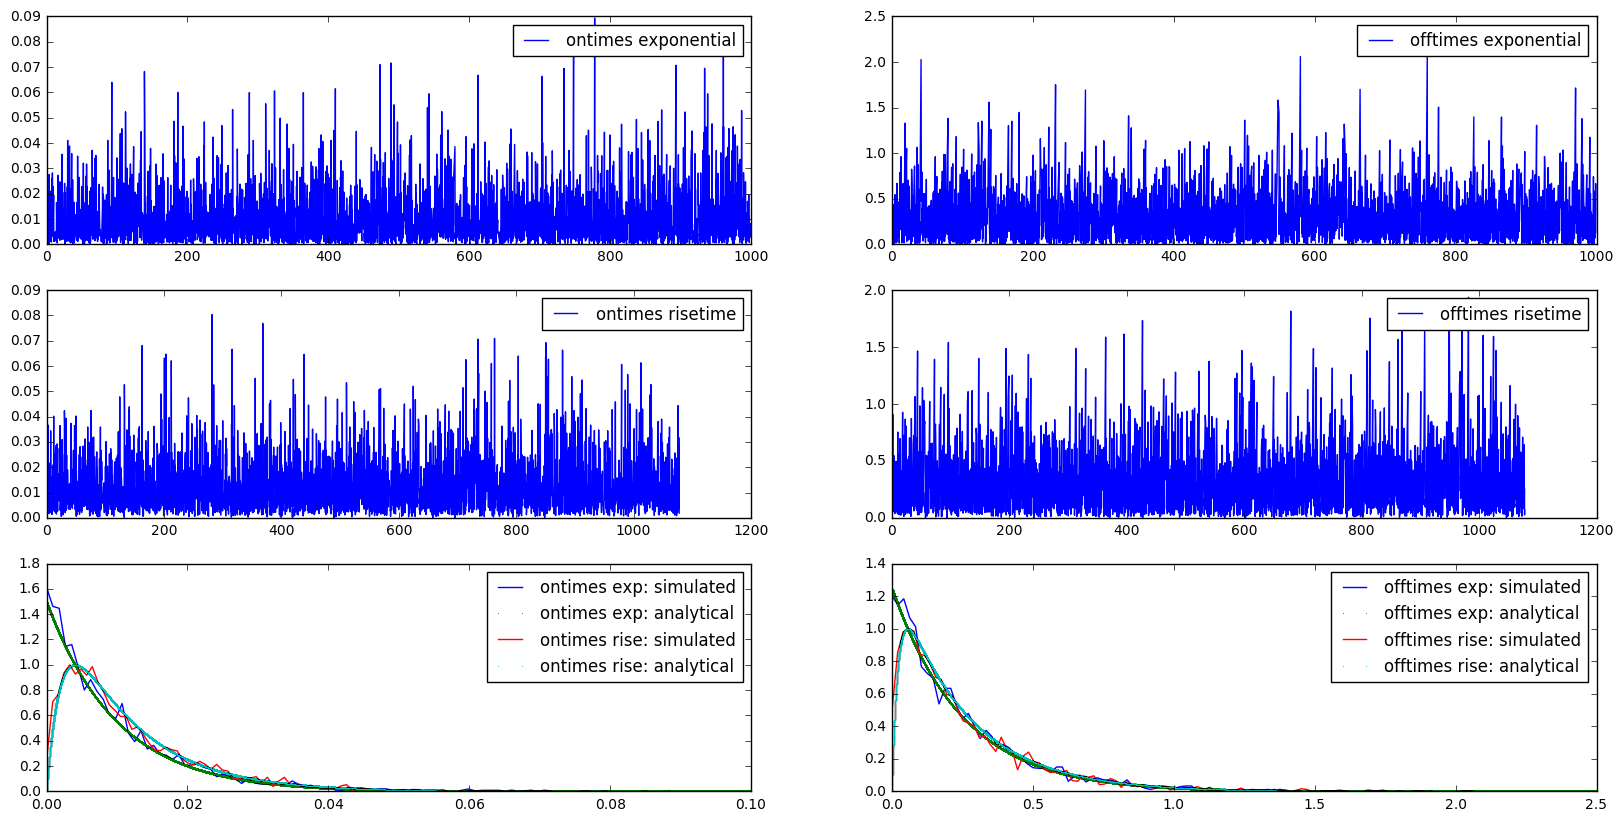

In [13]:
out = simulate_on_off_times(ton1=0.016, ton2=0.002, toff1=0.250,
                        toff2=0.02, time_len=1000, plotting=True);
[ontimes_exp_1, ontimes_exp_rise, offtimes_exp_1, offtimes_exp_rise] = out

## photonstamps from on-off times and counts

In [11]:
ontimes=ontimes_exp_1;
offtimes = offtimes_exp_rise;
timestamps, timestamps_marker = timestamps_from_onofftrace(ontimes, offtimes,
                                                           i_on_mu=3000, i_off_mu=200);

(5, 10)

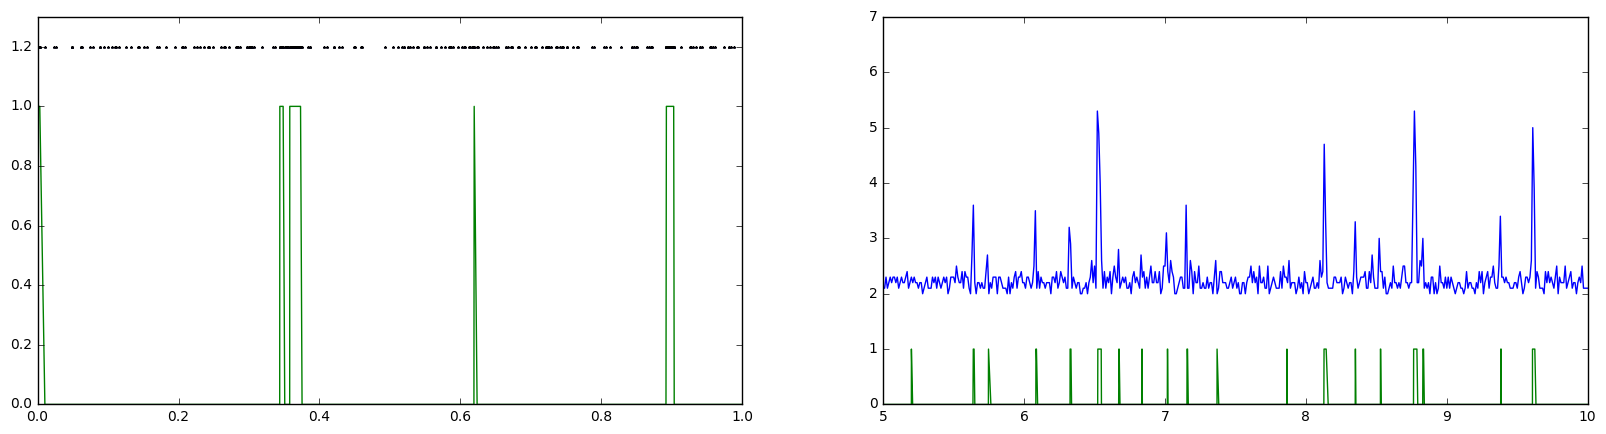

In [20]:
bintime = 10e-3;
bins = np.int((max(timestamps) - min(timestamps))/bintime)
hist, trace = np.histogram(timestamps, bins=bins)
# plt.plot(timestamps, np.ones_like(timestamps), '*',ms=5);
fig = plt.figure(figsize=(20, 5));
nrows=1; ncols=2;
ax00 = plt.subplot2grid((nrows, ncols), (0,0))
ax01 = plt.subplot2grid((nrows, ncols), (0,1))
ax00.plot(timestamps, 0.2+np.ones_like(timestamps), '*',ms=2);
ax00.plot(timestamps, timestamps_marker);
ax00.set_xlim(0, 1)
ax00.set_ylim(0, 1.3)
ax01.plot(trace[:-1], 2+hist*1e-3/bintime)
ax01.plot(timestamps, timestamps_marker)
ax01.set_xlim(5, 10)

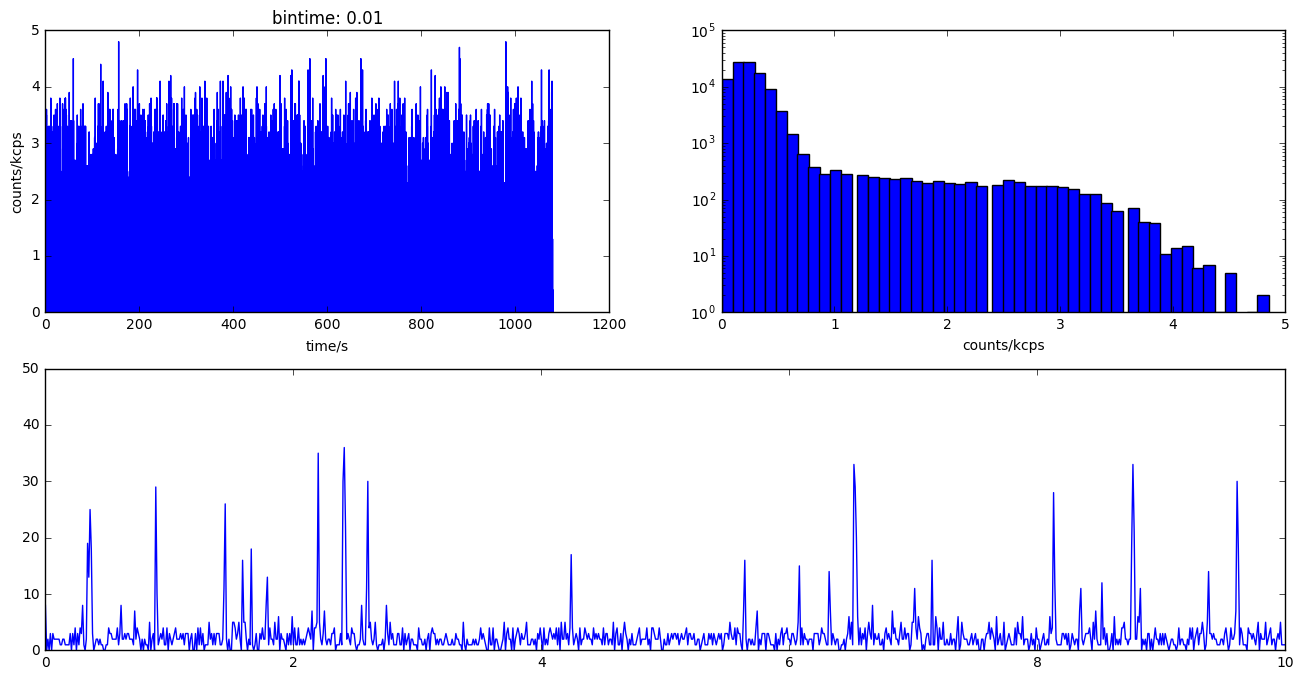

In [52]:
%run simulation.py
intensity_fit(timestamps, bintime=10e-3)

## simulate and save 

In [6]:
hdf5saved = save_simulated_trace(ton1=0.016, ton2=0.002, 
                                 toff1=0.250, toff2=0.02, 
                                 i_on_mu=3000, i_off_mu=200, 
                                 time_len=1000);

numpoint: 3759


# Simulated from Experimental data

In [5]:
def histogram_on_off_all_folder(folderlist= allfolders, input_potential=[100], pointnumbers=range(100),
                          bins_on=50, range_on=[0, 0.2], bins_off=50, range_off=[0, 0.5], plotting=False):
    t_ons = []; t_offs = [];
    for folder in folderlist:
        df_datn_emplot, df_FCS, folder = dir_mV_molNo(folder)
        df_specific = df_datn_emplot[df_datn_emplot['Point number'].isin(pointnumbers)]#keep all the points that exist
        df_specific = df_specific[df_specific['Potential'].isin(input_potential)]; df_specific.reset_index(drop=True, inplace=True)
        for i in range(len(df_specific)):
            Point_number = df_specific['Point number'][i]
            f_datn_path = df_specific['filepath[.datn]'].values[i]
            f_emplot_path = df_specific['filepath[.em.plot]'].values[i]
            df_emplot_filename = df_specific['filename[.em.plot]'][i]
            if os.path.isfile(f_emplot_path):
                try:
                    df_ton, df_toff, average_ton, average_toff, average_ton_err, average_toff_err = t_on_off_fromCP(f_emplot_path)
                except:
                    print('em.plot file: %s doesn''t contain proper data' %df_emplot_filename)
                    df_ton=[]; df_toff=[]
                    pass
            else:
                print('em.plot file of %s with potential %s doesn''t exist' %(Point_number, input_potential))
                df_ton=[]; df_toff=[]
            t_ons = np.concatenate((t_ons, df_ton), axis=0);
            t_offs = np.concatenate((t_offs, df_toff));
    if plotting == True:
        fig, axes = plt.subplots(1, 2, figsize=(20,8))
        n_on,bins_on,patches = axes[0].hist(t_ons, range=range_on,bins=bins_on)
        axes[0].set_xlabel(r'$\tau_{on}$')
        axes[0].set_ylabel('#')
        #axes[0].set_yscale('log')
        axes[0].set_title("ON time histogram at %s mV" %input_potential[0])
        n_off,bins_off,patches = axes[1].hist(t_offs, range=range_off,bins=bins_off)
        axes[1].set_xlabel(r'$\tau_{off}$')
        axes[1].set_ylabel('#')
        #axes[1].set_yscale('log')
        axes[1].set_title("OFF time histogram at %s mV" %input_potential[0])
    return(t_ons, t_offs, n_on, bins_on, n_off, bins_off)

In [5]:
def hist_2d_from_t_values(t_ons, t_offs,input_potential=100, x_shift=10, bins_on=40, range_on=[0, 0.01], bins_off=50, range_off=[0, 1], plots = True):
    t_ons=pd.Series(t_ons);t_offs=pd.Series(t_offs)
    t_on_shifted_1 = t_ons.shift(+1) ## shift up
    t_on_delay_1 = pd.DataFrame([t_on_shifted_1, t_ons]); t_on_delay_1=t_on_delay_1.T
    t_on_delay_1 = t_on_delay_1.dropna();
    t_off_shifted_1 = t_offs.shift(+1) ## shift up

    t_on_shifted_x = t_ons.shift(+x_shift) ## shift up
    t_off_shifted_x = t_offs.shift(+x_shift) ## shift up
    print('Number of on events: %d' %len(t_ons))
    print('Number of off events: %d' %len(t_offs))
    if plots==True:
        import matplotlib as mpl
        colormap=mpl.cm.RdBu_r
        fig = plt.figure(figsize=(16,8))

        ax1 = fig.add_subplot(2,3,1)#2,2,1
        C_on_1,Ex_on_1,Ey_on_1, figu = hist2d(t_on_shifted_1[1:], t_ons[1:], range=[range_on, range_on], bins=bins_on, norm=mpl.colors.LogNorm(), cmap=colormap)
        Ex_on_1,Ey_on_1 = meshgrid(Ex_on_1,Ey_on_1)
        #ax1.pcolormesh(Ex_on_1, Ey_on_1, C_on_1, cmap=colormap)#,norm=mpl.colors.LogNorm()
        colorbar()
        ax1.set_title('ON time Cu-Azu %smV' %input_potential)
        ax1.set_xlabel(r'$\tau_{on}/s$')
        ax1.set_ylabel(r'$\tau_{on}+1/s$')

        ax2 = fig.add_subplot(2,3,2)#2,2,1
        C_on_x,Ex_on_x,Ey_on_x, figu = hist2d(t_on_shifted_x[x_shift:], t_ons[x_shift:], range=[range_on, range_on], bins=bins_on, norm=mpl.colors.LogNorm(), cmap=colormap)
        Ex_on_x,Ey_on_x = meshgrid(Ex_on_x,Ey_on_x)
        #ax2.pcolormesh(Ex_on_x, Ey_on_x, C_on_x, cmap=colormap)#,norm=mpl.colors.LogNorm()
        colorbar()
        ax2.set_title('ON time Cu-Azu %smV' %input_potential)
        ax2.set_xlabel(r'$\tau_{on}/s$')
        ax2.set_ylabel(r'$\tau_{on}+%s/s$'%x_shift)

        ax3 = fig.add_subplot(2,3,3)
        C_on_diff = C_on_1-C_on_x;
        pcm=ax3.pcolormesh(Ex_on_x, Ey_on_x, C_on_diff,
                       norm=mpl.colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=C_on_diff.min(), vmax=C_on_diff.max()), cmap=colormap)
        fig.colorbar(pcm, ax=ax3, extend='max')

        ax4 = fig.add_subplot(2,3,4)
        C_off_1, Ex_off_1, Ey_off_1, figu= hist2d(t_off_shifted_1[1:], t_offs[1:], range=[range_off, range_off],bins=bins_off, norm=mpl.colors.LogNorm(), cmap=colormap);#, norm=mpl.colors.LogNorm()
        Ex_off_1, Ey_off_1 = meshgrid(Ex_off_1, Ey_off_1)
        colorbar()
        ax4.set_title('OFF time Cu-Azu %smV' %input_potential)
        ax4.set_xlabel(r'$\tau_{off}/s$')
        ax4.set_ylabel(r'$\tau_{off}+1/s$')

        ax5 = fig.add_subplot(2,3,5)
        C_off_x,Ex_off_x,Ey_off_x, figu = hist2d(t_off_shifted_x[x_shift:], t_offs[x_shift:], range=[range_off, range_off],bins=bins_off, norm=mpl.colors.LogNorm(), cmap=colormap);#, norm=mpl.colors.LogNorm()
        Ex_off_x,Ey_off_x = meshgrid(Ex_off_x,Ey_off_x)
        colorbar()
        ax5.set_title('OFF time Cu-Azu %smV' %input_potential)
        ax5.set_xlabel(r'$\tau_{off}/s$')
        ax5.set_ylabel(r'$\tau_{off}+%s/s$'%x_shift)

        ax6 = fig.add_subplot(2,3,6)
        C_off_diff=C_off_1-C_off_x
        pcm=ax6.pcolormesh(Ex_off_x, Ey_off_x, C_off_diff, norm=mpl.colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=C_off_diff.min(), vmax=C_off_diff.max()), cmap=colormap)
        fig.colorbar(pcm, ax=ax6, extend='max')
        plt.tight_layout()
        return()

Generating on off times from the distribution (probability distribution function) obtained in the experiment.
Resonable paramters:
100 mV: bins_on=200, range_on=[0, 0.04], bins_off=200, range_off=[0, 1]


em.plot file of 2.0 with potential [100] doesnt exist
em.plot file of 15.0 with potential [100] doesnt exist


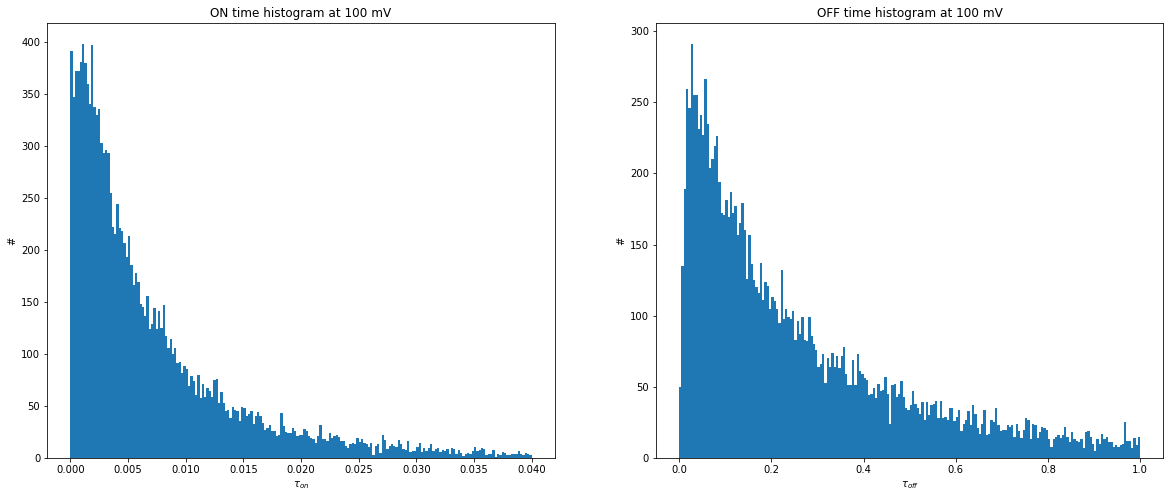

In [30]:
#
t_ons, t_offs, n_on, bins_on, n_off, bins_off = histogram_on_off_all_folder(folderlist= allfolders, input_potential=[100], pointnumbers=range(100), 
                                        bins_on=200, range_on=[0, 0.04], bins_off=200, range_off=[0, 1], plotting=True)

prob_on = n_on/max(n_on); prob_on = prob_on/sum(prob_on);
prob_off = n_off/max(n_off); prob_off = prob_off/sum(prob_off);
data_points = 1e6
t_ons_generated = np.random.choice(bins_on[:-1], data_points, p=prob_on)
t_off_generated = np.random.choice(bins_off[:-1], data_points, p=prob_off)

Number of on events: 1000000
Number of off events: 1000000


()

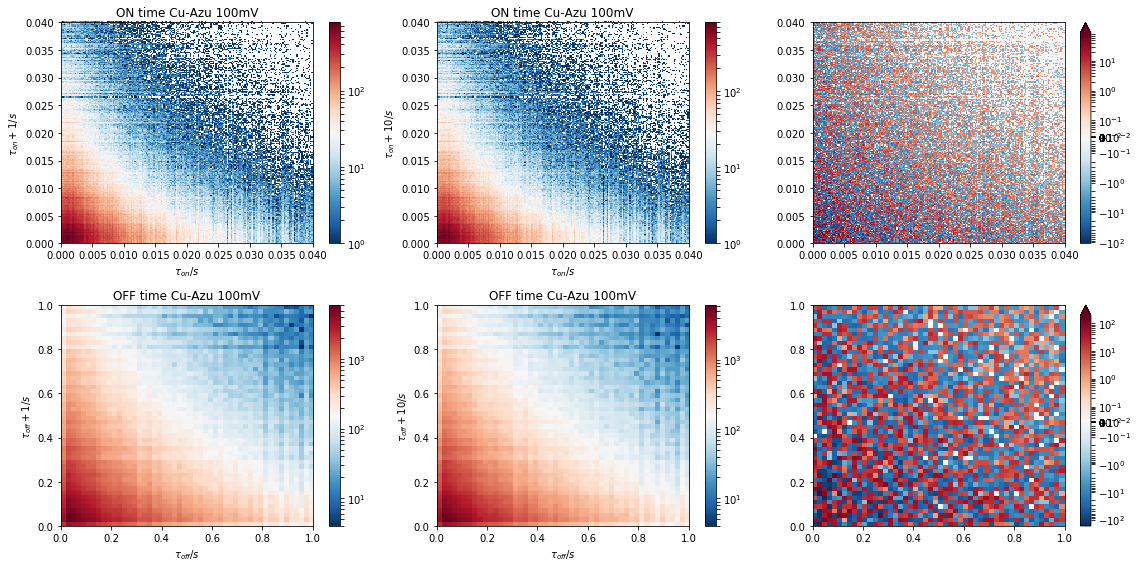

In [32]:
hist_2d_from_t_values(t_ons_generated, t_off_generated, x_shift=10, bins_on=200, range_on=[0, 0.04], bins_off=50, range_off=[0, 1], plots = True)

## Real trace: mean and var

### 0 mV

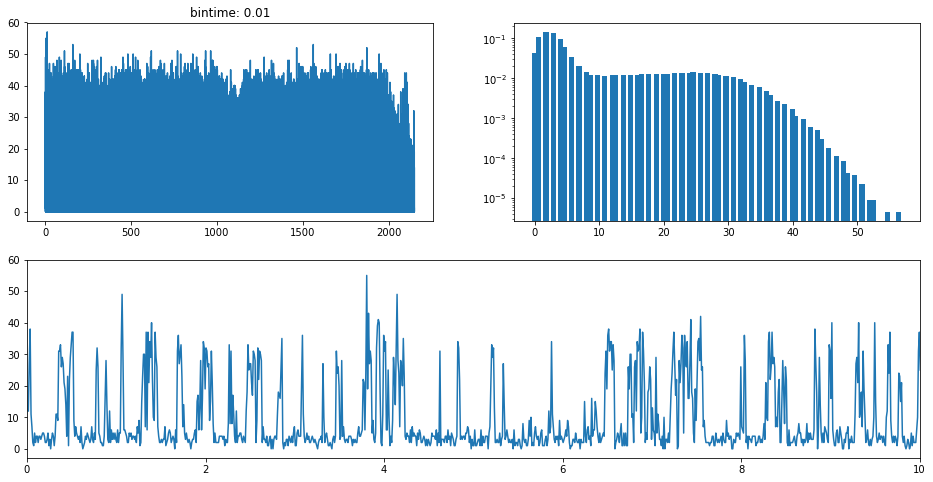

In [138]:
Point_11_0mV_S106 = '/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/\
S106d18May17_635_CuAzu655_longtime/S106d18May17_60.5_635_A6_CuAzu655_000mV(9).pt3/data/Point_A6_000mV(9)_60.5_2160s_11.pt3.datn'
df = pd.read_csv(Point_11_0mV_S106, header=None);
df=df[0]
intensity_fit(df, bintime=10e-3)

### 50 mV

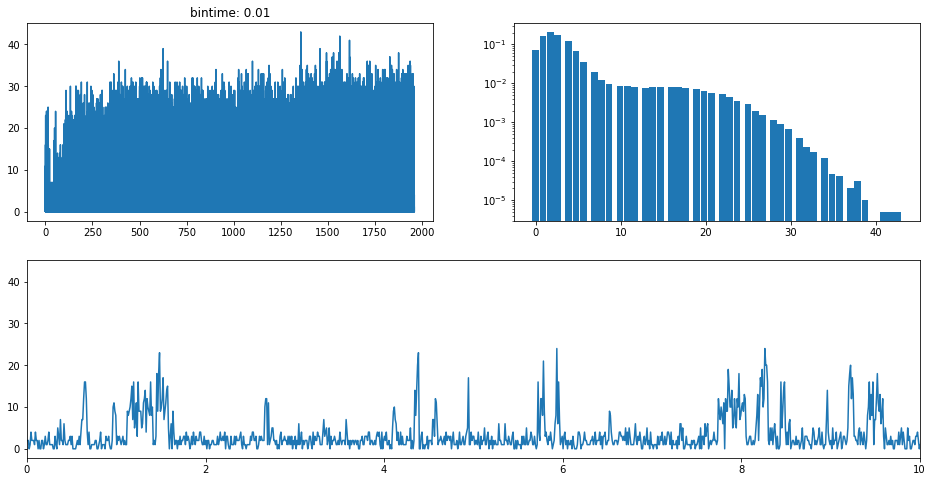

In [140]:
Point_22_50mV_S106 = '/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/\
S106d18May17_635_CuAzu655_longtime/S106d18May17_60.5_635_A7_CuAzu655_050mV(15).pt3/data/Point_A8_050mV(15)_60.5_1980s_22.pt3.datn';
df = pd.read_csv(Point_22_50mV_S106, header=None);
df=df[0]
intensity_fit(df, bintime=10e-3)

## 100 mV

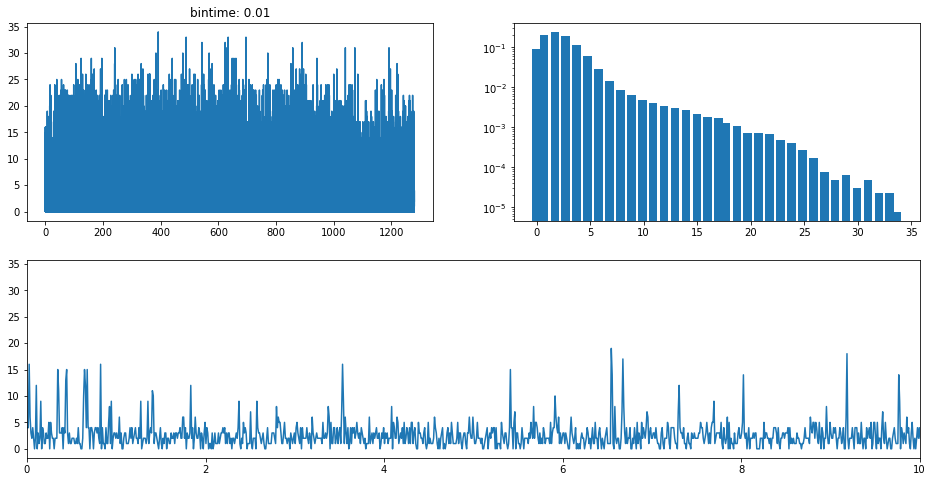

In [139]:
Point_26_100mV_S106 = '/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/\
data/S106d18May17_635_CuAzu655_longtime/S106d18May17_60.5_635_A9_CuAzu655_100mV(18)/data/Point_A9_100mV(18)_60.5_1600s_26.pt3.datn'
df = pd.read_csv(Point_26_100mV_S106, header=None);
df=df[0]
intensity_fit(df, bintime=10e-3)